In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding",  # this disables constant folding
#     "--xla_cpu_use_thunk_runtime=false",
# )
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+422.g0ee2f3d17.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.28 GB available memory.


## Functions for plotting islands (or not?)

In [111]:
def plot_fieldlines_and_surfaces(field, equ, ntransit=200, nrho=9, size=0.3, outside=False, **kwargs):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    if outside:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, 2))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
        rmax = np.max(r0)
        rmin = np.min(r0)
        r0 = np.linspace(rmin, rmax + (rmax-rmin)*0.05, nrho)
        z0 = np.zeros_like(r0)
    else:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, nrho))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
    fig, ax = plot_surfaces(equ)
    fig, ax = poincare_plot(
        field,
        r0,
        z0,
        NFP=equ.NFP,
        ax=ax,
        color="k",
        size=size,
        ntransit=ntransit,
        bounds_R=(0, max(r0) + 1.0),
        bounds_Z=(-max(z0) - 1.2, max(z0) + 1.2),
        **kwargs,
    )
    return fig, ax

In [112]:
def optimize_coils_regcoil(surf, equ, num_coils=16, return_k=False):
    # create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
    surface_current_field = FourierCurrentPotentialField.from_surface(
        surf,
        I=0,
        # manually setting G to value needed to provide the equilibrium's toroidal flux,
        # though this is not necessary as it gets set automatically inside the solve_regularized_surface_current function
        G=np.asarray(
            [
                -equ.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0]
                / mu_0
                * 2
                * np.pi
            ]
        ),
        # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
        sym_Phi="sin",
    )

    surface_current_field.change_Phi_resolution(M=12, N=12)

    # create the evaluation grid (where Bn will be minimized on plasma surface)
    # and source grid (discretizes the source K for Biot-Savart and where |K| will be penalized on winding surface)
    Megrid = 20
    Negrid = 20
    Msgrid = 20
    Nsgrid = 20

    eval_grid = LinearGrid(M=Megrid, N=Negrid, NFP=equ.NFP, sym=False)
    # ensure that sym=False for source grid so the field evaluated from the surface current is accurate
    # (i.e. must evaluate source over whole surface, not just the symmetric part)
    # NFP>1 is ok, as we internally will rotate the source through the field periods to sample entire winding surface
    sgrid = LinearGrid(M=Msgrid, N=Nsgrid, NFP=equ.NFP, sym=False)

    lambda_regularization = np.append(np.array([0]), np.logspace(-30, 1, 20))

    # solve_regularized_surface_current method runs the REGCOIL algorithm
    fields, data = solve_regularized_surface_current(
        surface_current_field,  # the surface current field whose geometry and Phi resolution will be used
        eq=equ,  # the Equilibrium object to minimize Bn on the surface of
        source_grid=sgrid,  # source grid
        eval_grid=eval_grid,  # evaluation grid
        current_helicity=(
            1*surface_current_field.NFP,
            -1,
        ),  # pair of integers (M_coil, N_coil), determines topology of contours (almost like  QS helicity),
        #  M_coil is the number of times the coil transits poloidally before closing back on itself
        # and N_coil is the toroidal analog (if M_coil!=0 and N_coil=0, we have modular coils, if both M_coil
        # and N_coil are nonzero, we have helical coils)
        # we pass in an array to perform scan over the regularization parameter (which we call lambda_regularization)
        # to see tradeoff between Bn and current complexity
        lambda_regularization=lambda_regularization,
        # lambda_regularization can also be just a single number in which case no scan is performed
        vacuum=True,  # this is a vacuum equilibrium, so no need to calculate the Bn contribution from the plasma currents
        regularization_type="regcoil",
        chunk_size=40,
    )
    surface_current_field = fields[
        0
    ]  # fields is a list of FourierCurrentPotentialField objects

    if return_k:
        return surface_current_field
    else:
        coilset = surface_current_field.to_CoilSet(num_coils=num_coils, stell_sym=True)
        return coilset


def optimize_field_and_plot_result(eq, nrho=18, ntransit=200, size=0.3, offset=0.25, outside=False):
    eq.surface = eq.get_surface_at(rho=1.0)
    # create the constant offset surface
    surf = eq.surface.constant_offset_surface(
        offset=offset,  # desired offset
        M=16,  # Poloidal resolution of desired offset surface
        N=16,  # Toroidal resolution of desired offset surface
        grid=LinearGrid(M=32, N=32, NFP=eq.NFP),
    )
    optimized_coilset = optimize_coils_regcoil(surf, eq, num_coils=8, return_k=True)
    return plot_fieldlines_and_surfaces(
        optimized_coilset, eq, nrho=nrho, ntransit=ntransit, size=size, outside=outside
    )

# Generate Eq with Target Iota values

In [152]:
eq = get("ATF")
eq.change_resolution(NFP=3)
eq.current = 0
eq.pressure = 0
eq.solve(verbose=3, maxiter=100, ftol=1e-2);
eq0 = eq.copy()

/CODES/DESC/desc/utils.py:572: UserWarning:

Setting toroidal current profile on an equilibrium with fixed rotational transform, removing existing rotational transform profile.



Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 88.5 ms
Timer: Objective build = 123 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Timer: Objective build = 113 ms
Timer: LinearConstraintProjection build = 2.34 sec
Number of parameters: 2050
Number of objectives: 3978
Timer: Initializing the optimization = 2.67 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method           

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 3.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 3.



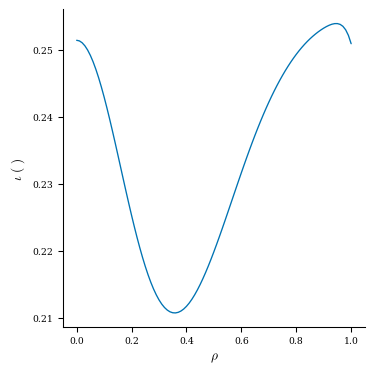

In [153]:
plot_1d(eq, "iota")
plot_3d(eq, "|B|")

In [155]:
k = 1
R_modes = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[
            np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
        ],
    )
)
Z_modes = eq.surface.Z_basis.modes[
    np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
]
constraints = (
    ForceBalance(eq), 
    FixBoundaryR(eq, modes=R_modes),
    FixBoundaryZ(eq, modes=Z_modes),
    FixPressure(eq),
    FixCurrent(eq),
    FixPsi(eq),
)

In [156]:
iota_grid = LinearGrid(rho=jnp.array([0.2, 1.0]), M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
AR = eq.compute("R0/a")["R0/a"]
objective = ObjectiveFunction(
    [
        RotationalTransform(
            eq, grid=iota_grid, target=jnp.array([0.2, 0.72]), weight=1
        ),
        AspectRatio(eq, target=AR, weight=1, normalize=False),
        Elongation(eq, bounds=(0, 3)),
    ]
)

In [157]:
eq.optimize(
    objective,
    constraints,
    maxiter=15,
    ftol=1e-2,
    verbose=3,
);

Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 34.4 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 54.3 ms
Building objective: elongation
Precomputing transforms
Timer: Precomputing transforms = 55.2 ms
Timer: Objective build = 159 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 85.1 ms
Timer: Objective build = 105 ms
Timer: Objective build = 1.33 ms
Timer: Eq Update LinearConstraintProjection build = 521 ms
Timer: Proximal projection build = 6.90 sec
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 193 ms
Timer: LinearConstraintProjection build = 865 ms
Number of parameters: 8
Number of objectives: 4
Timer: Initializing the optimization = 8.01 sec

Starting optimization
Using method: proximal-lsq-exact
Solver opti

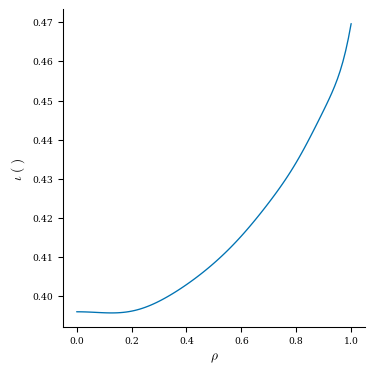

In [158]:
plot_1d(eq, "iota");

##########################################################
Calculating Phi_SV for lambda_regularization = 0.00000e+00
##########################################################
chi^2 B = 7.35916e-07
min Bnormal = 2.94454e-17 (T)
Max Bnormal = 1.25807e-05 (T)
Avg Bnormal = 1.76976e-06 (T)
min Bnormal = 6.83001e-18 (unitless)
Max Bnormal = 2.91815e-06 (unitless)
Avg Bnormal = 4.10506e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 1.00000e-30
##########################################################
chi^2 B = 7.35916e-07
min Bnormal = 1.02387e-17 (T)
Max Bnormal = 1.25810e-05 (T)
Avg Bnormal = 1.76978e-06 (T)
min Bnormal = 2.37492e-18 (unitless)
Max Bnormal = 2.91822e-06 (unitless)
Avg Bnormal = 4.10509e-07 (unitless)
##########################################################
Calculating Phi_SV for lambda_regularization = 4.28133e-29
##########################################################
chi^2 B = 7.35933e-07
m

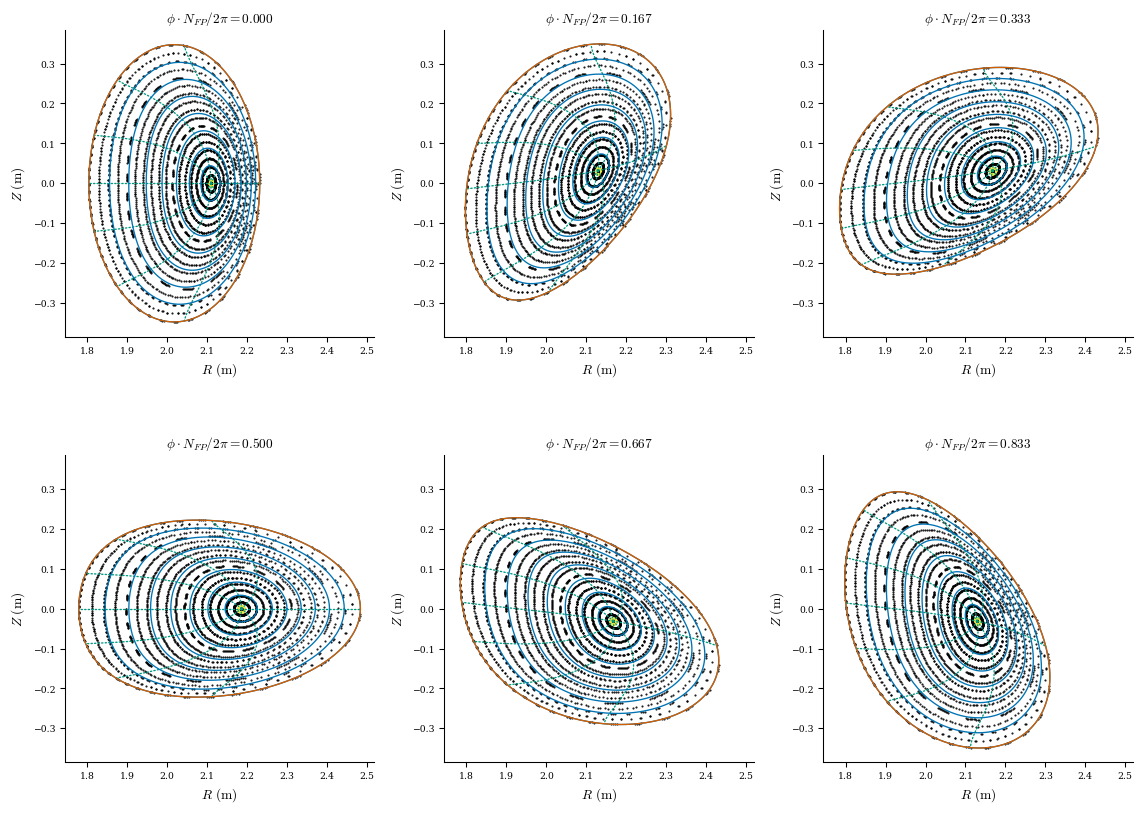

In [150]:
optimize_field_and_plot_result(eq, ntransit=200, offset=0.2);